In [10]:
from sklearn.neighbors import NearestNeighbors
from numpy.linalg import eig
import numpy as np
import cv2
import os
import sys
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go


back_camera_path = os.path.abspath('video/back_video_masked.avi')

***Back Camera Intrinsics***

Intrinsic matrix K(1,1) K(2,2) K(1,3) K(2,3) 
519.4039      518.0534      656.7379      451.5029 


Radial distortion coef k1 k2 k3 
-0.26584    0.067382  -0.0073529 


***Left Camera Intrinsics***

Intrinsic matrix K(1,1) K(2,2) K(1,3) K(2,3) 
1007.4921      1001.9244      622.32689      481.29046 

Radial distortion coef k1 k2 k3 
-0.37839     0.18775   -0.051045 


In [11]:
def matching_features_SCIKITLEARN(sift_points):
    """Feature matching using nearest neighbours, for pairs of consecutive frames"""
    
    matches=[]
    Threshold=0.75
        
    for s in range(len(sift_points)-1):
        frame1_descriptors = sift_points[s][0][2:,:] #descriptor values of every feature point for video frame s (current shape: 128x5000)
        frame1_descriptors = np.transpose(frame1_descriptors) # transpose -> current shape: 5000x128 - > 5000 points/queries each with 128 features/columns
        #fit data of features from frame 1 to NearestNeighbour. When we ask for matches from this method, it should give us the 2 closest points to the point given
        nbrs = NearestNeighbors(n_neighbors=2, algorithm='auto').fit(frame1_descriptors) 

        #predict matches for the other frame:
        
        frame_drescriptors = np.transpose(sift_points[s+1][0][2:,:]) #the same as done some lines above but for frame s+1
        # Find the 2 nearest neighbors
        distances, indices = nbrs.kneighbors(frame_drescriptors) 
        # indices is a 5000x2 shape matrix -> for each of the 5000 given feature points of frame_drescriptors it gives the 2 closest features from video frame 1
        # distances is a measure of distance between the feature points of frame_drescriptors and each of the two givenneighbours from the indices matrix - it has the same size as indices
        
        features_matches=np.empty([4,0])
        features_not_mateched=[]
        for i in range(len(distances)): 
            if distances[i,0]< Threshold*distances[i,1]:
                #match is good for first neighbour found
                features_matches= np.hstack((  features_matches   , np.array([[int(i)],[int(indices[i,0])], [distances[i,0]],[distances[i,1]]])  ))
            else:                
                #point is not good
                features_not_mateched.append(i) #features from this frame that were not matched
        
        features_matches = features_matches[:, features_matches[1, :].argsort()] # this sorts the check_for_duplicates matrix in accordance to the values of it's second line
        features_matches_deletedColumns= features_matches.copy()

        for i in reversed (range (1, features_matches.shape[1])): #loop that starts in the last feature - because it deletes elements with their indexes from list check_for_duplicates_deletedColumns
            # this has to be done starting from the end to not change the index of columns

            # duplicates are adjacent because of sort
            if features_matches[1,i-1] == features_matches[1,i]:
                # if the value of the indice i and i-1 are equal, then there is one feature matched to 2 features of the new frame - we need to delete one of the matches
                if features_matches[2,i-1] <= features_matches[2,i]: #check distance of i and i-1. And remove the one with the most distance
                    features_matches_deletedColumns= np.delete(features_matches_deletedColumns, i-1, 1) #remove duplicate feature matching (deletes one column - np dimension 1)
                    features_not_mateched.append(features_matches[0,i-1]) #append number of feature that was deleted to features not matched
                else:
                    features_matches_deletedColumns= np.delete(features_matches_deletedColumns, i, 1) 
                    features_not_mateched.append(features_matches[0,i]) 
        
        matched_inThis_frame = features_matches_deletedColumns[:, features_matches_deletedColumns[0, :].argsort()] #to be in order in acoordance to index of frame s

        matches.append( (matched_inThis_frame[0:2,:]))

    return matches

In [12]:
def count_frames(video_path):
    """Displays the video and counts the number of frames"""
    capture = cv2.VideoCapture(os.path.abspath(video_path))
    total_frames = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
    print("Total frames of the video: ", total_frames)

def extract_features(video_path, number_points, k):
    """Extracts the features from the video and stores them in a list"""
    capture = cv2.VideoCapture(os.path.abspath(video_path))
    sift_points = [] #nome a definir no config
    nr_points = number_points
    sift = cv2.SIFT_create(nr_points) #number of sift points
    k = k
    count_frames(video_path)
    while k <= 100:
        capture.set(cv2.CAP_PROP_POS_FRAMES, k)
        success, frame = capture.read() #read the video
        if success:
            frame_points = []
            gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY) #convert image to gray
            key_points, descriptors = sift.detectAndCompute(gray,None) 
            
            frame_points = ([key_points[0].pt[0],key_points[0].pt[1]]+descriptors[0].tolist())
            for i in range(1,len(key_points)):
                 temp_column = ([key_points[i].pt[0],key_points[i].pt[1]]+descriptors[i].tolist())
                 frame_points = np.column_stack((frame_points,temp_column))  
        sift_points.append(frame_points) #append everything into a list 
        k += 200
    print("(Nº features, Nº descriptors per feature): ", descriptors.shape)
    print("Nº of frames extracted: ", len(sift_points))
    return sift_points, nr_points

In [13]:
def back_left_matches(matches, sift_back,sift_left):
    Back_matches = []
    left_matches = []

    for i in range(len(matches[0][0])):
        back = []
        left = []
        b =int(matches[0][0][i])
        l = int(matches[0][1][i])
        back.append(sift_back[0][0][b])
        back.append(sift_back[0][1][b])

        left.append(sift_left[0][0][l])
        left.append(sift_left[0][1][l])

        Back_matches.append(back)
        left_matches.append(left)

    return Back_matches, left_matches

In [14]:
def undistort_points(back_points_distorted):
    Back_CameraMatrix = np.array([[519.4039, 0, 656.7379],[ 0, 518.0534, 451.5029],[ 0, 0, 1] ])
    Back_RadialDistortion =np.array( [-0.26584,0.067382,0,0,-0.0073529,0,0,0,0,0,0,0,0,0 ])
    back_points_undistorted = cv2.undistortPoints(np.array(back_points_distorted),Back_CameraMatrix,Back_RadialDistortion)

    return back_points_undistorted, Back_CameraMatrix


In [69]:
both_cameras_sift = []
sift_back1, _ = extract_features(back_camera_path, 1500,0)  # Extracting only one frame from it 
sift_back2, _ = extract_features(back_camera_path, 1500,10)
both_cameras_sift.append(sift_back1)
both_cameras_sift.append(sift_back2)
matches = matching_features_SCIKITLEARN(both_cameras_sift)

#Select the points from the back camera and left camera that match
back_points_distorted1, back_points_distorted2 = back_left_matches(matches, sift_back1,sift_back2) 

#Undistort the previous points, and obtain their coordinates
back_points1, K_back = undistort_points(back_points_distorted1)
back_points2, _ = undistort_points(back_points_distorted2)

#Obtain the Essential Matrix from the two Cameras
E, mask = cv2.findEssentialMat(back_points1, back_points2, K_back, cv2.RANSAC, threshold=0.3) 

#Decompose the Essential Matrix to obtain the most likely Rotation and Translation
points, R, t, _ = cv2.recoverPose(E, back_points1, back_points2, K_back )

#Another Option:
# s = cv2.decomposeEssentialMat(E)    # s is a struct

Total frames of the video:  87
(Nº features, Nº descriptors per feature):  (1500, 128)
Nº of frames extracted:  1
Total frames of the video:  87
(Nº features, Nº descriptors per feature):  (1501, 128)
Nº of frames extracted:  1


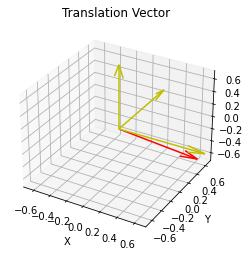

In [70]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x_axis = [1,0,0]
y_axis = [0,1,0]
z_axis = [0,0,1]
x_axis=np.reshape(x_axis,(3,1))
y_axis=np.reshape(y_axis,(3,1))
z_axis=np.reshape(z_axis,(3,1))
#VECTOR 1
ax.quiver(0, 0, 0, t[0], t[1], t[2], color='r', arrow_length_ratio=0.2)
#VECTOR 2
ax.quiver(0, 0, 0, x_axis[0], x_axis[1], x_axis[2], color='y', arrow_length_ratio=0.2)
ax.quiver(0, 0, 0, y_axis[0],y_axis[1], y_axis[2], color='y', arrow_length_ratio=0.2)
ax.quiver(0, 0, 0, z_axis[0],z_axis[1], z_axis[2], color='y', arrow_length_ratio=0.2)
#ax.quiver(0, 0, 0, v2[0], v2[1], v2[2], color='b', arrow_length_ratio=0.1)

ax.set_xlim([-0.7, 0.7])
ax.set_ylim([-0.7, 0.7])
ax.set_zlim([-0.7, 0.7])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Translation Vector')

plt.show()

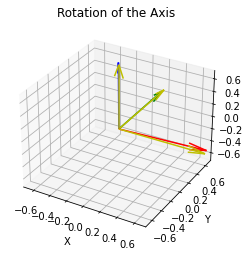

In [71]:
x_axis = [1,0,0]
y_axis = [0,1,0]
z_axis = [0,0,1]
x_axis=np.reshape(x_axis,(3,1))
y_axis=np.reshape(y_axis,(3,1))
z_axis=np.reshape(z_axis,(3,1))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = R.dot(x_axis)
y = R.dot(y_axis)
z = R.dot(z_axis)


#VECTOR 1
ax.quiver(0, 0, 0, x[0], x[1], x[2], color='r', arrow_length_ratio=0.2)
ax.quiver(0, 0, 0, x_axis[0], x_axis[1], x_axis[2], color='y', arrow_length_ratio=0.2)
#VECTOR 2
ax.quiver(0, 0, 0, y[0], y[1], y[2], color='g', arrow_length_ratio=0.2)
ax.quiver(0, 0, 0, y_axis[0],y_axis[1], y_axis[2], color='y', arrow_length_ratio=0.2)
#VECTOR 3
ax.quiver(0, 0, 0, z[0], z[1], z[2], color='b', arrow_length_ratio=0.2)
ax.quiver(0, 0, 0, z_axis[0],z_axis[1], z_axis[2], color='y', arrow_length_ratio=0.2)
#ax.quiver(0, 0, 0, v2[0], v2[1], v2[2], color='b', arrow_length_ratio=0.1)

ax.set_xlim([-0.7, 0.7])
ax.set_ylim([-0.7, 0.7])
ax.set_zlim([-0.7, 0.7])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Rotation of the Axis')

plt.show()

***New Changes 4/01/2023***

In [107]:
def drawlines(img1, img2, lines, pts1, pts2): 
    
    r, c = img1.shape 
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR) 
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR) 
      
    for r, pt1, pt2 in zip(lines, pts1, pts2): 
          
        color = tuple(np.random.randint(0, 255, 
                                        3).tolist()) 
          
        x0, y0 = map(int, [0, -r[2] / r[1] ]) 
        x1, y1 = map(int,  
                     [c, -(r[2] + r[0] * c) / r[1] ]) 
        img1 = cv2.line(img1,  
                        (x0, y0), (x1, y1), color, 3) 
        img1 = cv2.circle(img1, 
                          (int(pt1[0][0]),int(pt1[0][1])), 5, color, -1) 
        img2 = cv2.circle(img2,  
                          (int(pt2[0][0]),int(pt2[0][1])), 5, color, -1) 
    return img1, img2 

In [60]:
def frame_store(camera_path):
    cap = cv2.VideoCapture(camera_path)

        # Check if the video opened successfully
    if not cap.isOpened():
        print("Error: Could not open video.")
        exit()

    # Read the first frame
    ret, frame = cap.read()

    # Check if the frame was read successfully
    if not ret:
        print("Error: Could not read frame.")
        cap.release()
        exit()

# Release the video capture object
    cap.release()

    return frame


def frame_storek(camera_path,k):
    cap = cv2.VideoCapture(camera_path)

# Get the total number of frames in the video
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Check if there are at least 20 frames in the video
    if total_frames < 20:
        print("Error: The video has less than 20 frames.")
        exit()

# Set the frame number to 20
    frame_number = k
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number - 1)

# Read the 20th frame
    ret, frame_k = cap.read()

# Check if the frame was read successfully
    if not ret:
     print("Error: Could not read frame.")
     exit()
    return frame_k

In [84]:
#Extract Frames
back_camera_path2 = os.path.abspath('video/2023-04-29_16-40-01-back.mp4')
Back_RadialDistortion =np.array( [-0.26584,0.067382,0,0,-0.0073529,0,0,0,0,0,0,0,0,0 ])
frame_back = frame_store(back_camera_path2)
frame_back2 = frame_storek(back_camera_path2,10)

#Undistort the previous frames
img_back_undistorted = cv2.undistort(frame_back, K_back, Back_RadialDistortion)
img_back_undistorted2 = cv2.undistort(frame_back2, K_back, Back_RadialDistortion)

frame_back = img_back_undistorted
frame_back2 = img_back_undistorted2
cv2.imshow('Frame 0', frame_back2)
cv2.waitKey(0)
cv2.destroyAllWindows()

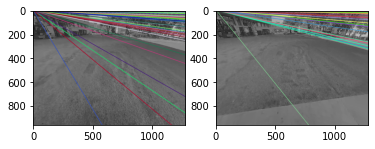

In [101]:
F, mask = cv2.findFundamentalMat(back_points1, back_points2, cv2.FM_LMEDS) 
  
# We select only inlier points 
back_points1_Fundamental = back_points1[mask.ravel() == 1] 
back_points2_Fundamental = back_points2[mask.ravel() == 1] 


linesLeft = cv2.computeCorrespondEpilines(back_points2_Fundamental.reshape(-1, 
                                                           1, 
                                                           2), 
                                          2, F) 
linesLeft = linesLeft.reshape(-1, 3) 
img5, img6 = drawlines(cv2.cvtColor(frame_back,cv2.COLOR_BGR2GRAY) , cv2.cvtColor(frame_back2,cv2.COLOR_BGR2GRAY),  
                       linesLeft, back_points1_Fundamental, 
                       back_points2_Fundamental) 
   
# Find epilines corresponding to  
# points in left image (first image) and 
# drawing its lines on right image 
linesRight = cv2.computeCorrespondEpilines(back_points1_Fundamental.reshape(-1, 1, 2),  
                                           1, F) 
linesRight = linesRight.reshape(-1, 3) 
  
img3, img4 = drawlines(cv2.cvtColor(frame_back2,cv2.COLOR_BGR2GRAY), cv2.cvtColor(frame_back,cv2.COLOR_BGR2GRAY),  
                       linesRight, back_points2_Fundamental, 
                       back_points1_Fundamental) 
   
plt.subplot(121), plt.imshow(img5) 
plt.subplot(122), plt.imshow(img3) 
plt.show() 

In [77]:
def click_event(image_index, event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        print(f"Image {image_index} - Pixel coordinates (x, y):", x, y)

# Read the two images
image1 = frame_back
image2 = frame_back2

# Display the images
cv2.imshow('Image1', image1)
cv2.imshow('Image2', image2)

# Set the callback function for mouse events for each image
cv2.setMouseCallback('Image1', lambda event, x, y, flags, param: click_event(1, event, x, y, flags, param))
cv2.setMouseCallback('Image2', lambda event, x, y, flags, param: click_event(2, event, x, y, flags, param))

# Wait for a key press and close the windows
cv2.waitKey(0)
cv2.destroyAllWindows()

Image 1 - Pixel coordinates (x, y): 1023 152
Image 2 - Pixel coordinates (x, y): 1001 148
Image 2 - Pixel coordinates (x, y): 726 145
Image 1 - Pixel coordinates (x, y): 733 148
Image 2 - Pixel coordinates (x, y): 807 101
Image 1 - Pixel coordinates (x, y): 825 103
Image 1 - Pixel coordinates (x, y): 859 121
Image 2 - Pixel coordinates (x, y): 841 118
Image 1 - Pixel coordinates (x, y): 918 143
Image 2 - Pixel coordinates (x, y): 892 138
Image 1 - Pixel coordinates (x, y): 149 131
Image 2 - Pixel coordinates (x, y): 166 128
Image 1 - Pixel coordinates (x, y): 96 120
Image 2 - Pixel coordinates (x, y): 151 121
Image 1 - Pixel coordinates (x, y): 172 134
Image 2 - Pixel coordinates (x, y): 187 130


In [105]:
pts1 = np.array([[[1023, 152]],[[733, 148]],[[825, 103]],[[859, 121]],[[918, 143]],[[149, 131]],[[96, 120]],[[172, 134]]])
pts2 = np.array([[[1001, 148]],[[726, 145]],[[807, 101]],[[841, 118]],[[892, 138]],[[166, 128]],[[151, 121]],[[187, 130]]])
F, _ = cv2.findFundamentalMat(pts1, pts2, cv2.FM_8POINT)

back_points1_Fundamental = pts1
back_points2_Fundamental = pts2

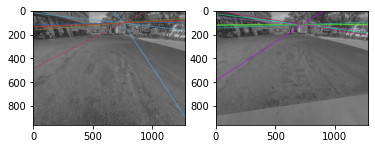

In [106]:
linesLeft = cv2.computeCorrespondEpilines(back_points2_Fundamental.reshape(-1, 
                                                           1, 
                                                           2), 
                                          2, F) 
linesLeft = linesLeft.reshape(-1, 3) 
img5, img6 = drawlines(cv2.cvtColor(frame_back,cv2.COLOR_BGR2GRAY) , cv2.cvtColor(frame_back2,cv2.COLOR_BGR2GRAY),  
                       linesLeft, back_points1_Fundamental, 
                       back_points2_Fundamental) 
   
# Find epilines corresponding to  
# points in left image (first image) and 
# drawing its lines on right image 
linesRight = cv2.computeCorrespondEpilines(back_points1_Fundamental.reshape(-1, 1, 2),  
                                           1, F) 
linesRight = linesRight.reshape(-1, 3) 
  
img3, img4 = drawlines(cv2.cvtColor(frame_back2,cv2.COLOR_BGR2GRAY), cv2.cvtColor(frame_back,cv2.COLOR_BGR2GRAY),  
                       linesRight, back_points2_Fundamental, 
                       back_points1_Fundamental) 
   
plt.subplot(121), plt.imshow(img5) 
plt.subplot(122), plt.imshow(img3) 
plt.show() 